In [1]:
import os
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [ ]:
class CatDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 2]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        return image, label

def create_dataframe(root_dir):
    image_paths = []
    breeds = []
    breed_ids = []
    classes = os.listdir(root_dir)
    
    for idx, class_name in enumerate(classes):
        class_path = os.path.join(root_dir, class_name)
        for img in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img))
            breeds.append(class_name)
            breed_ids.append(idx)

    return pd.DataFrame({"Путь к картинке": image_paths, "Порода": breeds, "Номер породы": breed_ids})

In [ ]:
# Приводим изображения сначала к одному размеру, а потом превращаем в вектор
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Dataset и DataLoader
root_dir = "cat_images_small"
dataframe = create_dataframe(root_dir)
dataset = CatDataset(dataframe=dataframe, transform=transform)

# Размер тренировочной и тестовой выборок
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

Сама модель CNN:

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: (8, 64, 64)
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # Output: (16, 32, 32)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8192, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)



num_classes = len(dataframe["Номер породы"].unique())
model = CNNModel(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

writer = SummaryWriter("runs/cnn_model")

In [5]:
import time

def train_model(model, train_loader, val_loader, epochs=10, log_dir="runs/model"):
    model.train()
    start_time = time.time()
    for epoch in range(epochs):
        train_loss, val_loss = 0.0, 0.0
        train_correct, val_correct, train_total, val_total = 0, 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        writer.add_scalar(f"{log_dir}/Loss/Train", train_loss / len(train_loader), epoch)
        writer.add_scalar(f"{log_dir}/Accuracy/Train", train_correct / train_total, epoch)
        writer.add_scalar(f"{log_dir}/Loss/Validation", val_loss / len(val_loader), epoch)
        writer.add_scalar(f"{log_dir}/Accuracy/Validation", val_correct / val_total, epoch)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_correct/train_total:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_correct/val_total:.4f}")
    print("Training complete in {:.0f}m {:.0f}s".format((time.time() - start_time) // 60, (time.time() - start_time) % 60))

train_model(model, train_loader, val_loader, epochs=30)

Epoch 1, Train Loss: 140.5744, Train Acc: 0.5392, Val Loss: 32.7699, Val Acc: 0.6200
Epoch 2, Train Loss: 113.3580, Train Acc: 0.6808, Val Loss: 29.8610, Val Acc: 0.6700
Epoch 3, Train Loss: 99.8919, Train Acc: 0.7242, Val Loss: 29.1920, Val Acc: 0.7033
Epoch 4, Train Loss: 88.9093, Train Acc: 0.7717, Val Loss: 26.5348, Val Acc: 0.7033
Epoch 5, Train Loss: 80.5586, Train Acc: 0.7892, Val Loss: 26.9194, Val Acc: 0.7167
Epoch 6, Train Loss: 69.1505, Train Acc: 0.8125, Val Loss: 25.8722, Val Acc: 0.7400
Epoch 7, Train Loss: 62.3774, Train Acc: 0.8550, Val Loss: 28.3592, Val Acc: 0.7033
Epoch 8, Train Loss: 55.8206, Train Acc: 0.8492, Val Loss: 32.5442, Val Acc: 0.6733
Epoch 9, Train Loss: 44.4240, Train Acc: 0.8817, Val Loss: 31.4640, Val Acc: 0.7033
Epoch 10, Train Loss: 37.5949, Train Acc: 0.9050, Val Loss: 35.4011, Val Acc: 0.7167
Epoch 11, Train Loss: 35.2141, Train Acc: 0.9192, Val Loss: 34.3101, Val Acc: 0.7467
Epoch 12, Train Loss: 25.2426, Train Acc: 0.9383, Val Loss: 37.8113, Val

Получение и визуализация эмбеддингов

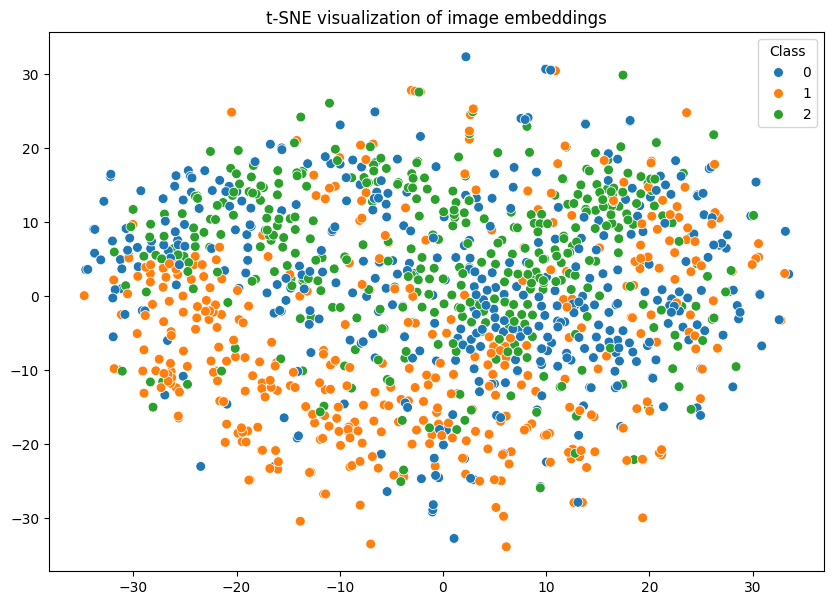

In [6]:
from sklearn.manifold import TSNE
import seaborn as sns

def get_embeddings(model, dataloader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            # Получаем только сверточные признаки
            features = model.features(images)
            features = features.view(features.size(0), -1)
            embeddings.append(features.cpu())
            labels.extend(lbls.numpy())
    return torch.cat(embeddings).numpy(), labels

# Получение эмбеддингов
train_embeddings, train_labels = get_embeddings(model, train_loader)

# TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
reduced_embeddings = tsne.fit_transform(train_embeddings)

# Визуализация
plt.figure(figsize=(10, 7))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=train_labels, palette="tab10", s=50)
plt.title("t-SNE visualization of image embeddings")
plt.legend(title="Class", loc="best")
plt.show()

Предобученная модель

In [9]:
from torchvision.models import resnet18, ResNet18_Weights

class TransferLearningModel(nn.Module):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()
        # Загрузим ResNet18 без последнего классификатора
        self.backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.backbone.fc = nn.Identity()  # Удаляем оригинальный классификатор
        # Новые слои
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

# Инициализация модели
transfer_model = TransferLearningModel(num_classes)
transfer_model.to(device)

# Обучение Transfer Learning модели
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001, weight_decay=1e-4)

In [10]:
import time

def train_model_with_timing(model, train_loader, val_loader, epochs=10):
    start_time = time.time()
    train_model(model, train_loader, val_loader, epochs=epochs)
    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f} seconds.")
    return total_time
    
# Обучение Transfer Learning модели
transfer_time = train_model_with_timing(transfer_model, train_loader, val_loader, epochs=30)

print(f"Transfer Learning Model Training Time: {transfer_time:.2f}s")

Epoch 1, Train Loss: 94.4152, Train Acc: 0.7317, Val Loss: 11.9217, Val Acc: 0.8833
Epoch 2, Train Loss: 40.5502, Train Acc: 0.9100, Val Loss: 8.6991, Val Acc: 0.9100
Epoch 3, Train Loss: 32.3454, Train Acc: 0.9233, Val Loss: 10.3372, Val Acc: 0.8767
Epoch 4, Train Loss: 27.1122, Train Acc: 0.9367, Val Loss: 9.7977, Val Acc: 0.8900
Epoch 5, Train Loss: 22.7228, Train Acc: 0.9483, Val Loss: 9.3322, Val Acc: 0.9200
Epoch 6, Train Loss: 17.2488, Train Acc: 0.9567, Val Loss: 13.1657, Val Acc: 0.9033
Epoch 7, Train Loss: 15.1502, Train Acc: 0.9658, Val Loss: 8.6798, Val Acc: 0.9067
Epoch 8, Train Loss: 12.7395, Train Acc: 0.9700, Val Loss: 10.9968, Val Acc: 0.8933
Epoch 9, Train Loss: 9.5224, Train Acc: 0.9883, Val Loss: 13.2763, Val Acc: 0.8533
Epoch 10, Train Loss: 7.7450, Train Acc: 0.9850, Val Loss: 9.6808, Val Acc: 0.8933
Epoch 11, Train Loss: 7.0056, Train Acc: 0.9858, Val Loss: 13.2312, Val Acc: 0.8933
Epoch 12, Train Loss: 7.1145, Train Acc: 0.9842, Val Loss: 12.7432, Val Acc: 0.890